In [1]:
import netCDF4 as nc
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from windrose import WindroseAxes

In [2]:
file_path = "../../awaken_data/kp.turbine.z01.b0.20201201.000000.wt001.nc"

In [3]:
def print_netcdf_structure(file_path):
    try:
        with nc.Dataset(file_path, 'r') as dataset:
            print(f"NetCDF File: {os.path.basename(file_path)}")
            print("\nGlobal Attributes:")
            for attr in dataset.ncattrs():
                print(f"  {attr}: {getattr(dataset, attr)}")

            print("\nDimensions:")
            for dim_name, dim in dataset.dimensions.items():
                print(f"  {dim_name}: {len(dim)}")

            print("\nVariables:")
            for var_name, var in dataset.variables.items():
                print(f"  {var_name}:")
                print(f"    Dimensions: {var.dimensions}")
                print(f"    Shape: {var.shape}")
                print(f"    Data type: {var.dtype}")
                print("    Attributes:")
                for attr in var.ncattrs():
                    print(f"      {attr}: {getattr(var, attr)}")

            print("\nGroups:")
            def print_group(group, indent="  "):
                for group_name, group_obj in group.groups.items():
                    print(f"{indent}{group_name}:")
                    print(f"{indent}  Variables:")
                    for var_name, var in group_obj.variables.items():
                        print(f"{indent}    {var_name}:")
                        print(f"{indent}      Dimensions: {var.dimensions}")
                        print(f"{indent}      Shape: {var.shape}")
                        print(f"{indent}      Data type: {var.dtype}")
                        print(f"{indent}      Attributes:")
                        for attr in var.ncattrs():
                            print(f"{indent}        {attr}: {getattr(var, attr)}")
                    print_group(group_obj, indent + "  ")

            print_group(dataset)

    except Exception as e:
        print(f"Error reading NetCDF file: {e}")

In [4]:
def create_df_from_netcdf(file_path):
    try:
        with nc.Dataset(file_path, 'r') as dataset:
            time = nc.num2date(dataset.variables['WTUR.DateTime'][:], dataset.variables['WTUR.DateTime'].units)
            
            data = {
                'time': time,
                'wind_speed': dataset.variables['WMET.HorWdSpd_10m_Avg'][:],
                'wind_direction': dataset.variables['WMET.HorWdDir_10m_Avg'][:],
                'power': dataset.variables['WTUR.W_10m_Avg'][:],
                'temperature': dataset.variables['WMET.EnvTmp_10m_Avg'][:],
                'turbulence_intensity': dataset.variables['WMET.TI_10m_Avg'][:],
                'yaw_angle': dataset.variables['WYAW.YwAng_10m_Avg'][:],
                'blade_pitch_angle': dataset.variables['WROT.BlPthAngVal1_10m_Avg'][:]
            }

        df = pd.DataFrame(data)
        df.set_index('time', inplace=True)
        return df

    except Exception as e:
        print(f"Error reading NetCDF file: {e}")
        return None

In [5]:
def plot_time_series(df, variable):
    # Time series plot of wind speed and power
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x=df.index, y='wind_speed', label='Wind Speed')
    sns.lineplot(data=df, x=df.index, y='power', label='Power')
    plt.title('Wind Speed and Power Over Time')
    plt.xlabel('Time')
    plt.ylabel('Value') 
    plt.legend()
    plt.show()
    

In [6]:
def plot_scatter_wind_speed_power(df):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x='wind_speed', y='power')
    plt.title('Scatter Plot of Wind Speed vs Power')
    plt.xlabel('Wind Speed')
    plt.ylabel('Power')
    plt.show()

In [7]:
def plot_wind_rose(wind_direction, wind_speed):
    plt.figure(figsize=(10, 10))
    ax = WindroseAxes.from_ax()
    ax.bar(wind_direction, wind_speed, normed=True, opening=0.8, edgecolor='white')
    ax.set_legend()
    plt.title('Wind Rose')
    plt.show()

In [8]:
def plot_temperature_distribution(df):
    plt.figure(figsize=(12, 6))
    sns.histplot(df['temperature'], bins=20, kde=True)
    plt.title('Temperature Distribution')
    plt.xlabel('Temperature')
    plt.ylabel('Frequency')
    plt.show()

In [9]:
def plot_heatmap_correlation(df):
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Heatmap of Correlation Matrix')
    plt.show()

In [10]:
def plot_boxplot_wind_speed(df):
    df['hour'] = df.index.hour
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='hour', y='wind_speed')
    plt.title('Wind Speed Distribution by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Wind Speed')
    plt.show()
    

In [ ]:
print_netcdf_structure(file_path)

In [11]:
df = create_df_from_netcdf(file_path)

In [ ]:
plot_time_series(df, 'wind_speed')

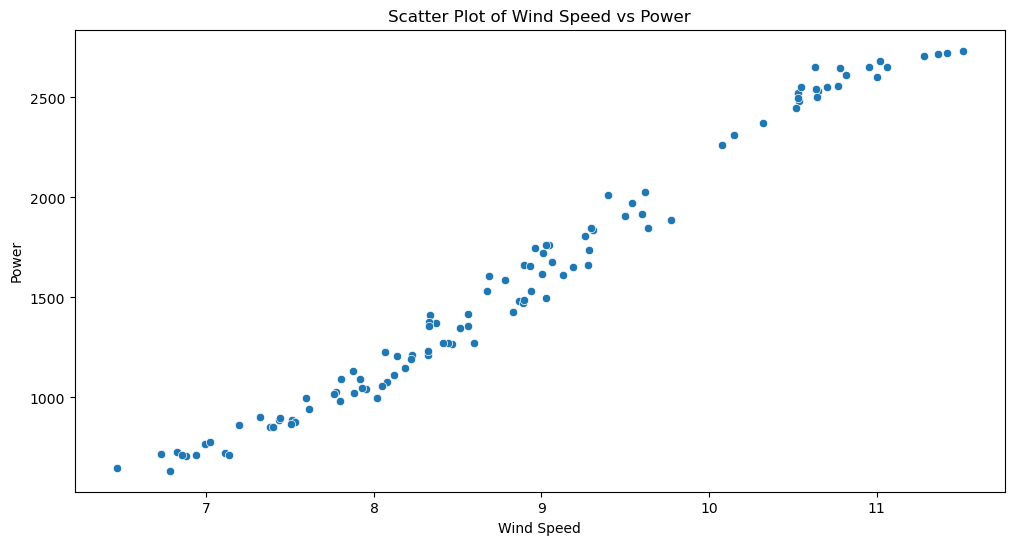

In [12]:
plot_scatter_wind_speed_power(df)

<Figure size 1000x1000 with 0 Axes>

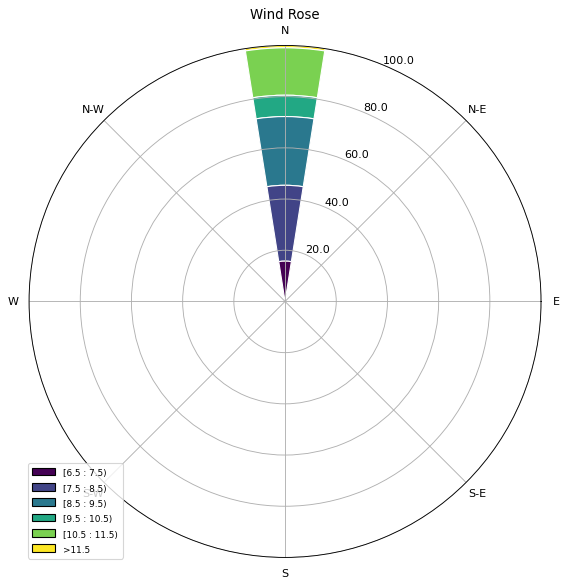

In [13]:
plot_wind_rose(df['wind_direction'], df['wind_speed'])

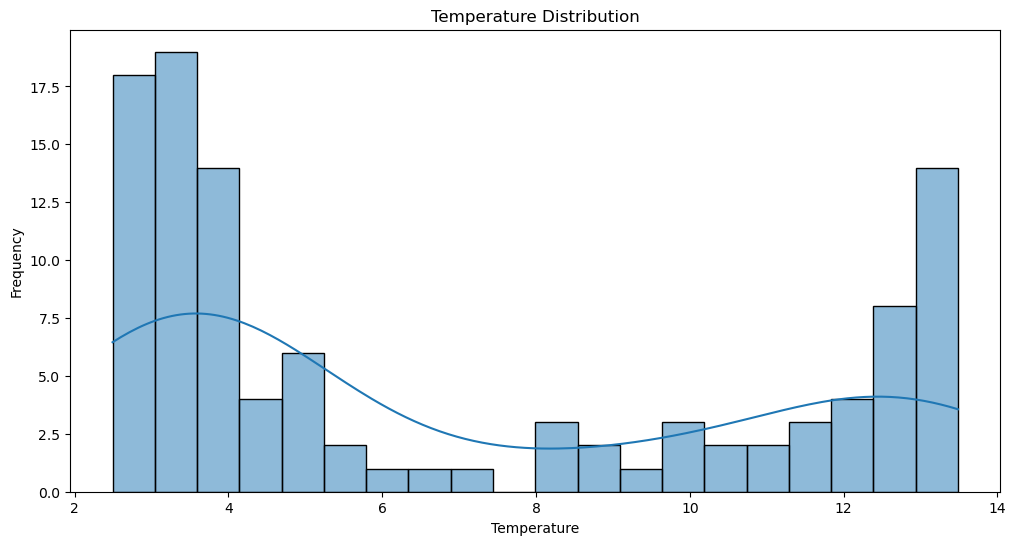

In [14]:
plot_temperature_distribution(df)

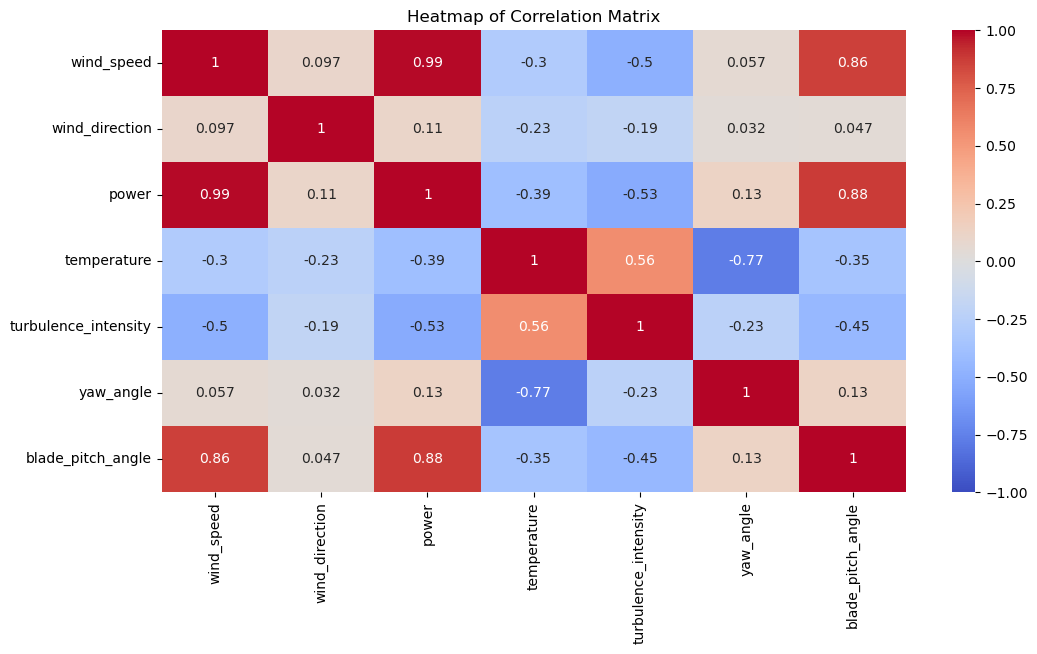

In [15]:
plot_heatmap_correlation(df)

In [16]:
plot_boxplot_wind_speed(df)

AttributeError: 'Index' object has no attribute 'hour'